## Import statements

In [247]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Exploratory Data Analysis

In [248]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [249]:
print "Rows: ", df.shape[0]
print "Columns: ", df.shape[1]
df.head()

Rows:  110527
Columns:  14


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Notice that values for "Gender" and "No-show" are strings instead of bool. These will need to be transformed  before they can be used as features for machine learning. There's also an opportunity to do One-Hot encoding on "Neighbourhood" to split each variable into a feature for machine learning.

In [250]:
df.isnull().any()

PatientId         False
AppointmentID     False
Gender            False
ScheduledDay      False
AppointmentDay    False
Age               False
Neighbourhood     False
Scholarship       False
Hipertension      False
Diabetes          False
Alcoholism        False
Handcap           False
SMS_received      False
No-show           False
dtype: bool

There are no null-values in the dataset which indicates it has already been cleaned for missing values.

## Data Wrangling

In [251]:
# Replace 'M' and 'F' with 1 and 0 for 'Gender' and 'Yes' and 'No'
# with 1 and 0 for 'No-show'
df['Gender'] = df['Gender'].map({'M':1, 
                                 'F':0}
                               )
df['No-show'] = df['No-show'].map({'Yes':1, 
                                   'No':0}
                                 )

In [252]:
# Renaming columns to fix typos, inconsistency and spelling mistakes
df.rename(columns={'AppointmentID':'AppointmentId',
                   'Handcap':'Handicap', 
                   'Hipertension':'Hypertension'}, 
          inplace=True
         )

df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,2.987250e+13,5642903,0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,5.589978e+14,5642503,1,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,4.262962e+12,5642549,0,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,0
3,8.679512e+11,5642828,0,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
4,8.841186e+12,5642494,0,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,0


In [253]:
def no_show_class():
    '''Count the values of No-show to spot whether classes are imbalanced or not'''
    no_show = 0
    for value in df['No-show']:
        if value == 1:
            no_show += 1
    print "\n Out of", len(df['No-show']), "records,", no_show, "didn't show up, i.e.", round(float(no_show) / float(len(df['No-show'])), 4)*100,"%"

print "Below is the split of values in 'No-show': 0 = showed up and 1 = didn't show up: \n"
print df['No-show'].value_counts()
no_show_class()

Below is the split of values in 'No-show': 0 = showed up and 1 = didn't show up: 

0    88208
1    22319
Name: No-show, dtype: int64

 Out of 110527 records, 22319 didn't show up, i.e. 20.19 %


Classes of 'No-show' are imbalanced and something we have to take into account when the dataset is going to be split into train and test. A stratified shuffle split is likely going to be ideal for cross-validating our machine learning model due to its randomised validations to increase the likelihood of the imbalanced classes for cross validation.

In [254]:
# Checking the range for 'Age' to spot outliers
print "Age range: ", sorted(df['Age'].unique())

Age range:  [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]


The youngest patient is -1 years old and the oldest is 115. It is clear the the youngest patient has to be removed since it's an impossibility and an outlier in our machine learning model. Likewise with patients older than 100.

Text(0,0.5,u'Patients')

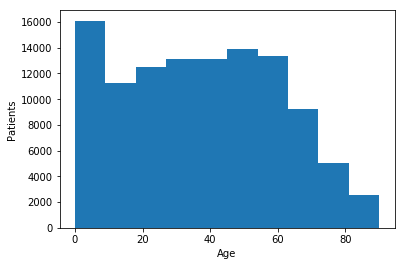

In [280]:
# Distribution of 'Age'
plt.figure();
age_hist = df['Age'].plot.hist(bins=10)
age_hist.set_xlabel("Age")
age_hist.set_ylabel("Patients")

It is apparent from the histogram above that patients aged above 90 are few and outliers.

In [265]:
# Only keep records of patients where they are between 0-90 in age to remove outliers.
df = df[(df.Age >= 0) & (df.Age <= 90)]

min_age = df['Age'].min()
max_age = df['Age'].max()
print "Age now spans values from: {} to {}.".format(min_age, max_age)

Age now spans values from: 0 to 90.


0    71619
1    38599
Name: Gender, dtype: int64


Text(0,0.5,u'Patients')

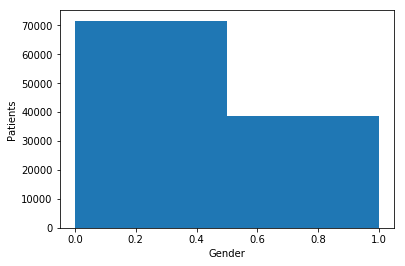

In [283]:
# Gender split
print df['Gender'].value_counts()
gender_hist = df['Gender'].plot.hist(bins=2)
gender_hist.set_xlabel("Gender")
gender_hist.set_ylabel("Patients")

There are almost twice as many female patients in this dataset than male.

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.
‘ScheduledDay’ tells us on what day the patient set up their appointment.
‘Neighborhood’ indicates the location of the hospital.
‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.

What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?